In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

In [58]:
# Load the dataset
df = pd.read_csv("../dataset/simple_engineered/augmented_data.csv")

In [59]:
# 1. ROC Curve and AUC
def roc_curve_and_auc(y_val, y_prob):
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

In [60]:
# 2. Goal Rate by Percentile (Binned by 5%)
def goal_rate_by_percentile(y_val, y_prob):
    df_val = pd.DataFrame({'y_val': y_val, 'y_prob': y_prob})
    df_val['percentile'] = pd.qcut(df_val['y_prob'], 100, labels=False, duplicates='drop') + 1  # Percentiles from 1 to 100
    goal_rate_by_percentile = df_val.groupby('percentile')['y_val'].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(goal_rate_by_percentile.index, goal_rate_by_percentile, marker='o')
    plt.title("Goal Rate by Percentile")
    plt.xlabel("Shot Probability Model Percentile")
    plt.ylabel("Goal Rate (#goals / (#goals + #no_goals))")
    plt.ylim(0, 1) # Set the y-axis range from 0 to 1
    plt.grid(True)  # Optional: Add a grid for better readability

    # Reverse the x-axis
    plt.gca().invert_xaxis()
    
    plt.show()


In [61]:
# 3. Cumulative Proportion of Goals by Percentile
def cumulative_proportion_of_goals(y_val, y_prob):
    df_val = pd.DataFrame({'y_val': y_val, 'y_prob': y_prob})
    df_val = df_val.sort_values('y_prob', ascending=False).reset_index(drop=True)

    # Calculate cumulative goals and proportion
    cumulative_goals = df_val['y_val'].cumsum()
    total_goals = df_val['y_val'].sum()
    cumulative_goal_percentage = cumulative_goals / total_goals

    # Percentile bins (from 100% to 0%)
    percentiles = np.linspace(100, 0, len(cumulative_goal_percentage))

    # Plot cumulative proportion of goals
    plt.figure(figsize=(10, 6))
    plt.plot(percentiles, cumulative_goal_percentage, marker='o', label="Cumulative Proportion")
    plt.title("Cumulative Proportion of Goals by Model Percentile")
    plt.xlabel("Shot Probability Model Percentile")
    plt.ylabel("Cumulative Proportion of Goals")
    plt.grid(True)

    # Reverse the x-axis
    plt.gca().invert_xaxis()

    plt.legend()
    plt.show()


    # 4. Reliability Diagram (Calibration Curve)
    CalibrationDisplay.from_predictions(y_val, y_prob, n_bins=10, strategy='uniform')
    plt.title("Reliability Diagram (Calibration Curve)")

    plt.show()

In [62]:
features = ['distance_from_net', 'angle_from_net']
X = df[features]
X.fillna(X.mean(), inplace=True)
y = df['is_goal']
y.fillna(0, inplace=True)

/var/folders/nw/jb15k8p55ms_s5kkmwgsvmv40000gn/T/ipykernel_28126/1637390586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


In [63]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# Logistic Regression Models
models = {
    "Distance Only": LogisticRegression().fit(X_train[['distance_from_net']], y_train),
    "Angle Only": LogisticRegression().fit(X_train[['angle_from_net']], y_train),
    "Distance + Angle": LogisticRegression().fit(X_train, y_train),
}

In [65]:
# Predictions
predictions = {
    model_name: {
        "y_pred": model.predict(X_val[features_subset]),
        "y_prob": model.predict_proba(X_val[features_subset])[:, 1]
    }
    for model_name, (model, features_subset) in {
        "Distance Only": (models["Distance Only"], ['distance_from_net']),
        "Angle Only": (models["Angle Only"], ['angle_from_net']),
        "Distance + Angle": (models["Distance + Angle"], features)
    }.items()
}

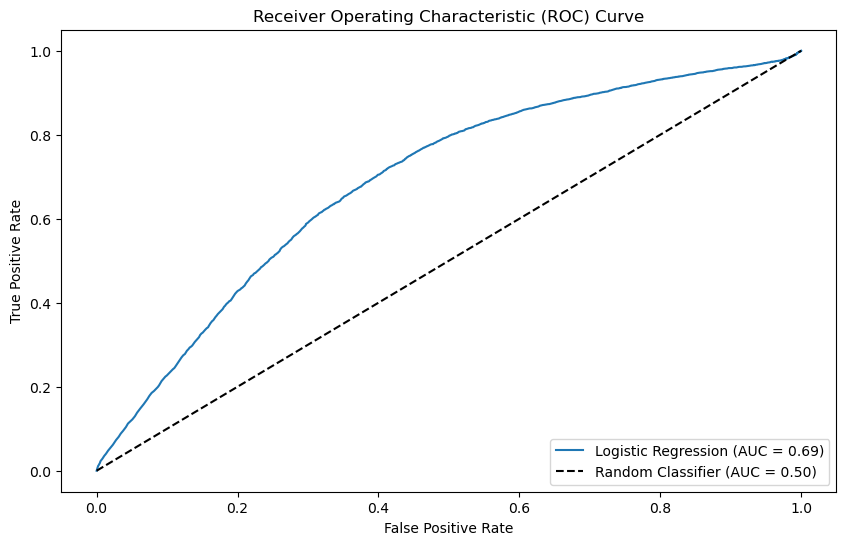

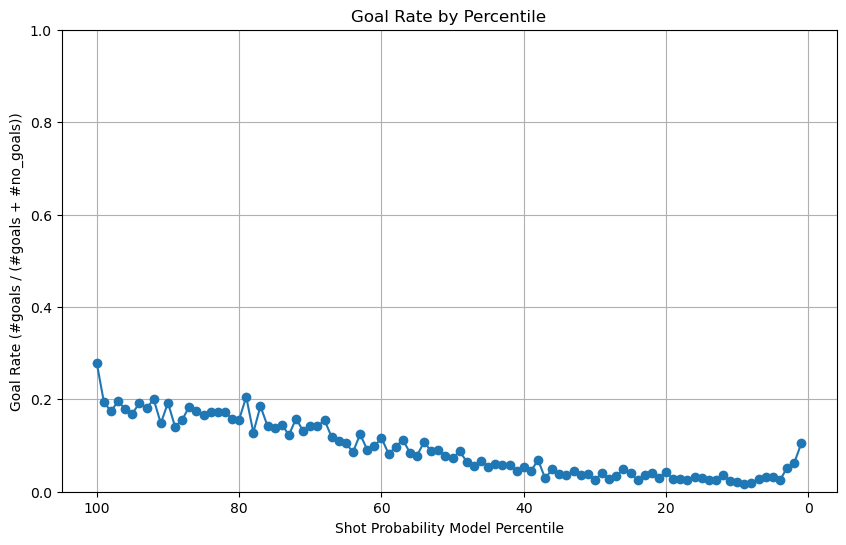

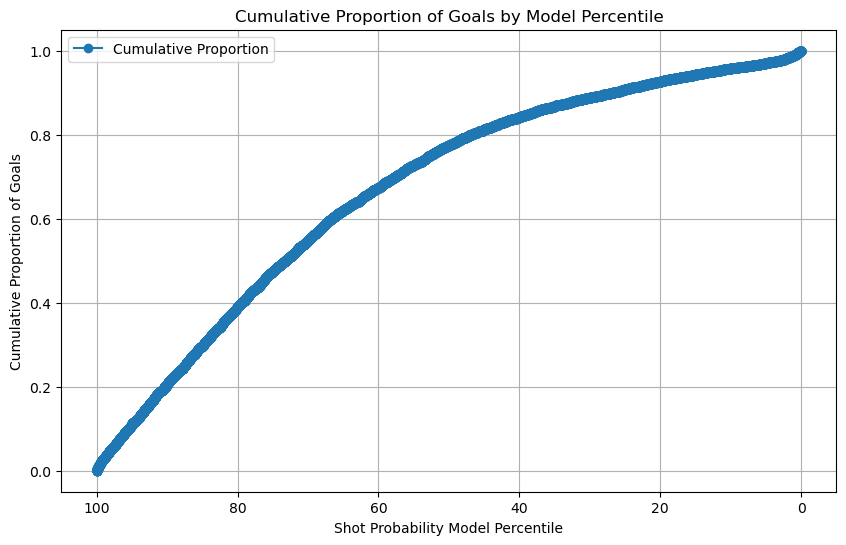

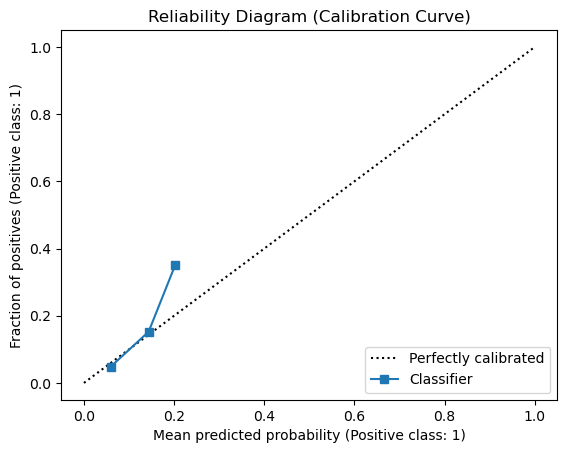

In [66]:
roc_curve_and_auc(y_val, predictions["Distance Only"]["y_prob"])
goal_rate_by_percentile(y_val, predictions["Distance Only"]["y_prob"])
cumulative_proportion_of_goals(y_val, predictions["Distance Only"]["y_prob"])

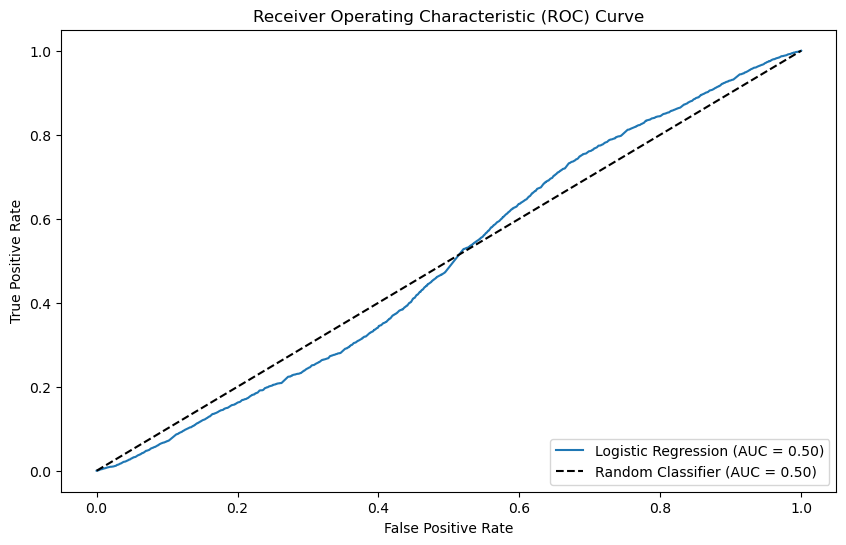

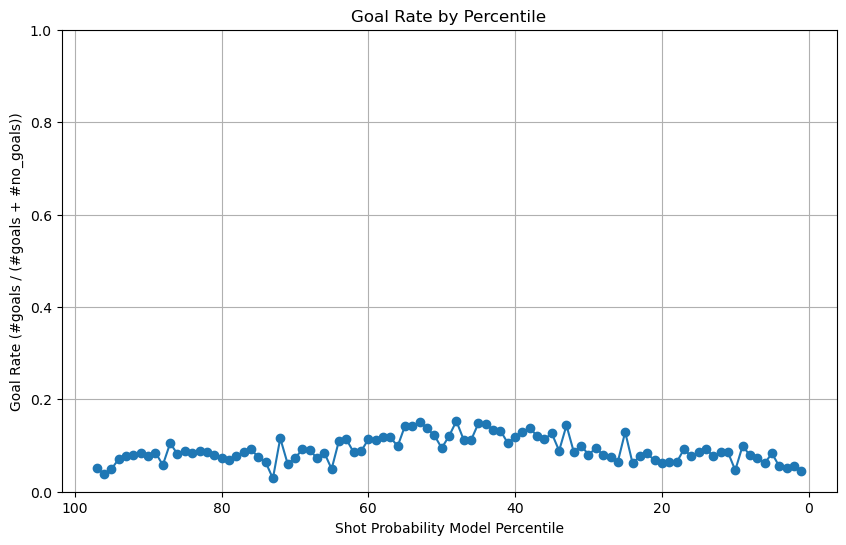

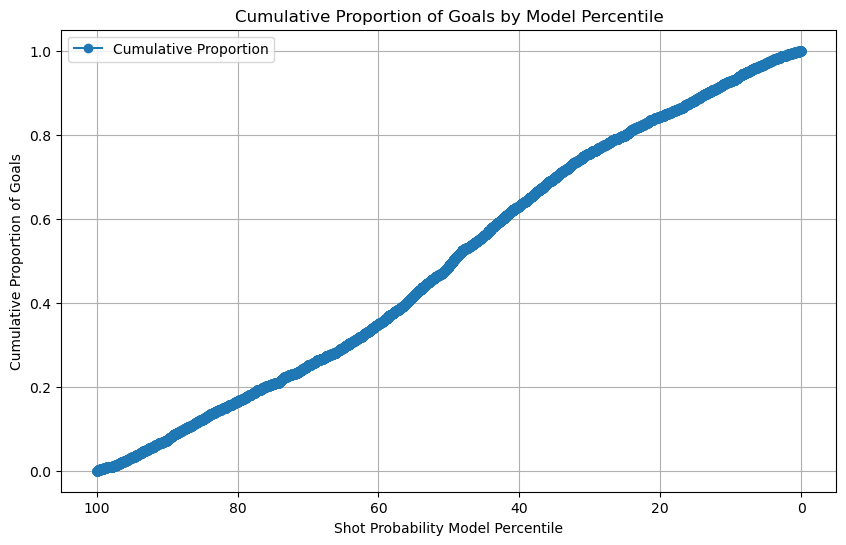

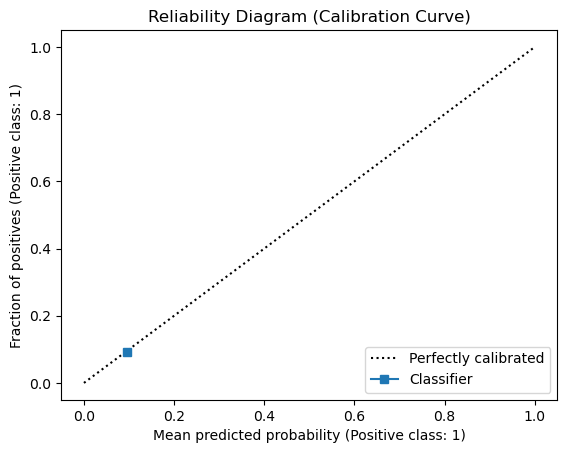

In [67]:
roc_curve_and_auc(y_val, predictions["Angle Only"]["y_prob"])
goal_rate_by_percentile(y_val, predictions["Angle Only"]["y_prob"])
cumulative_proportion_of_goals(y_val, predictions["Angle Only"]["y_prob"])

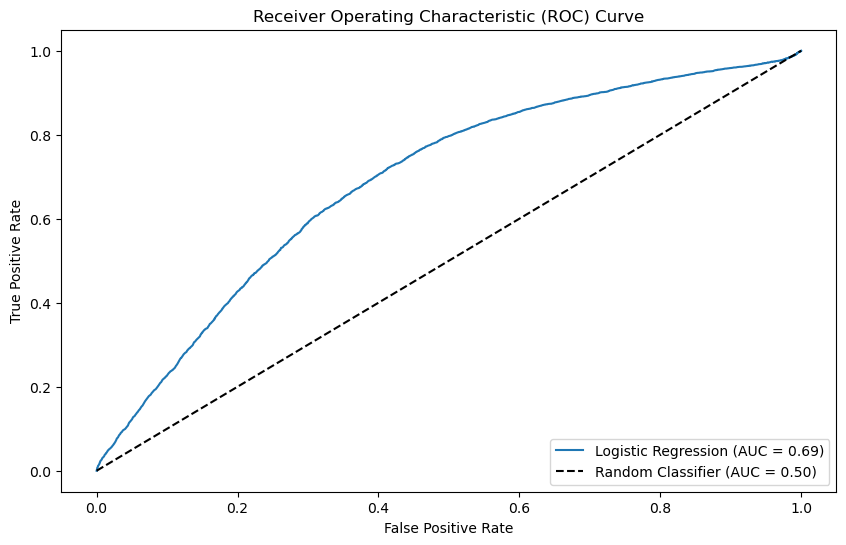

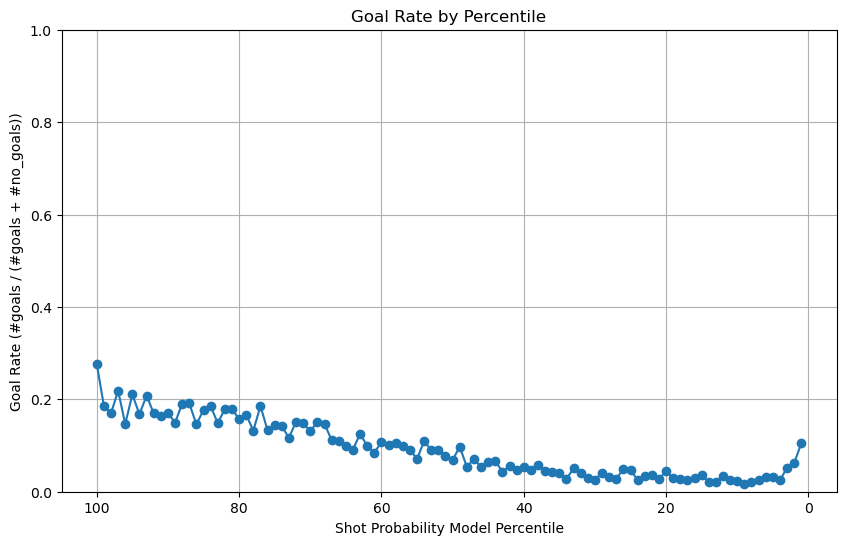

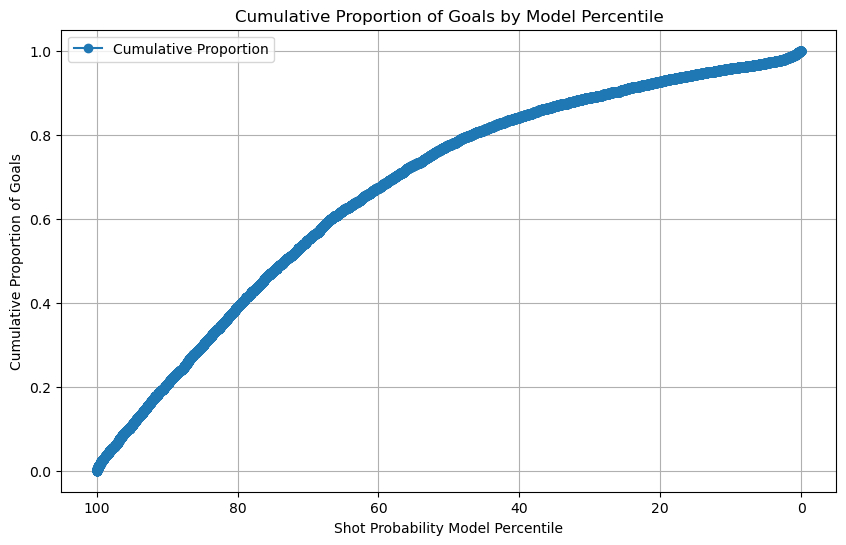

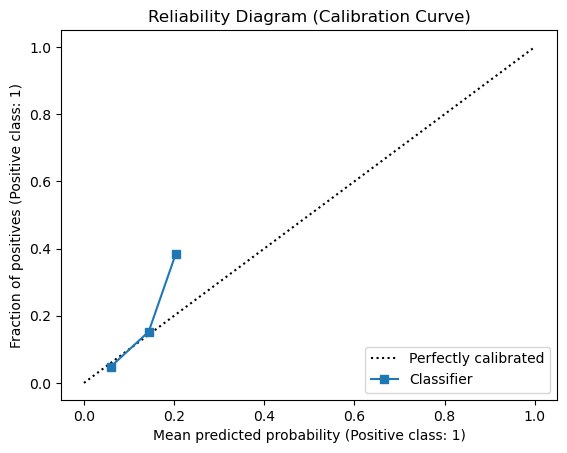

In [68]:
roc_curve_and_auc(y_val, predictions["Distance + Angle"]["y_prob"])
goal_rate_by_percentile(y_val, predictions["Distance + Angle"]["y_prob"])
cumulative_proportion_of_goals(y_val, predictions["Distance + Angle"]["y_prob"])

In [69]:
# Random Baseline
predictions["Random Baseline"] = {
    "y_prob": np.random.uniform(0, 1, len(y_val))
}

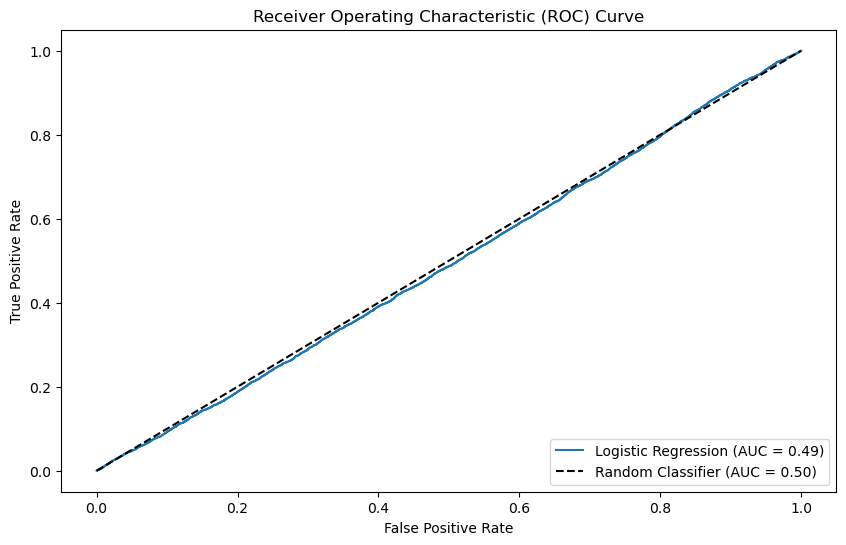

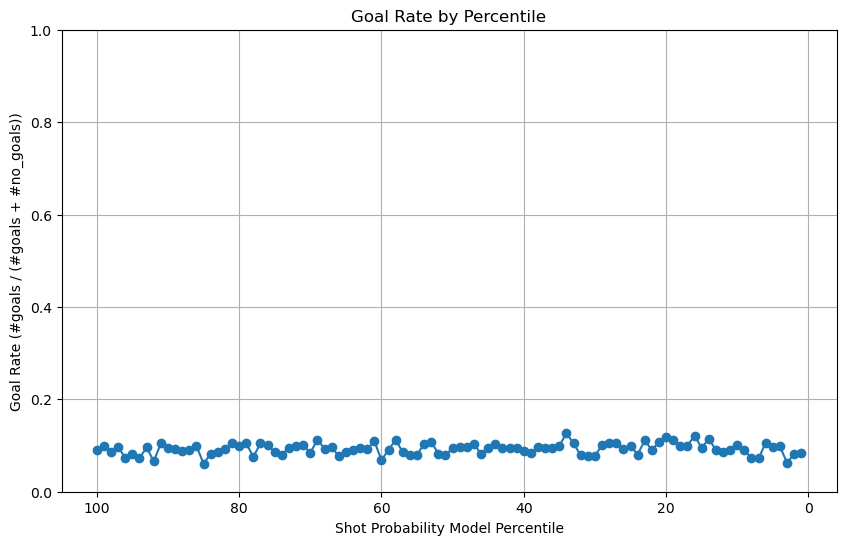

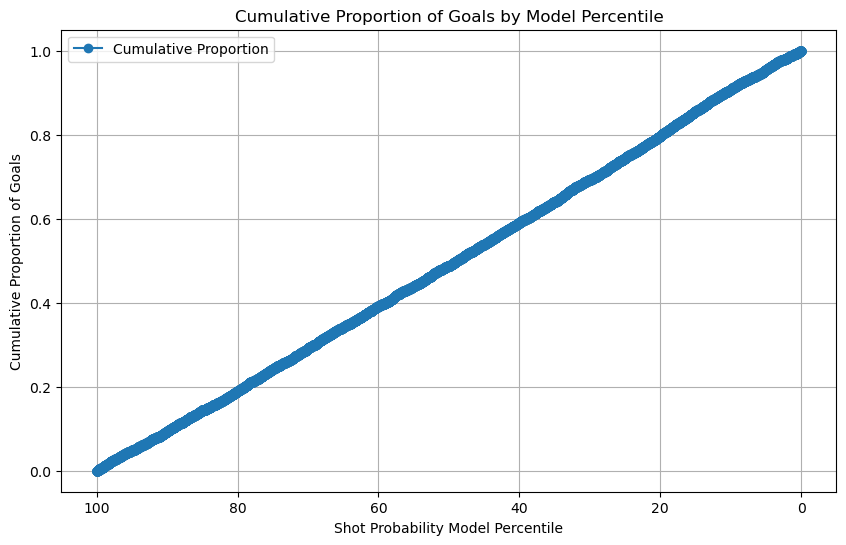

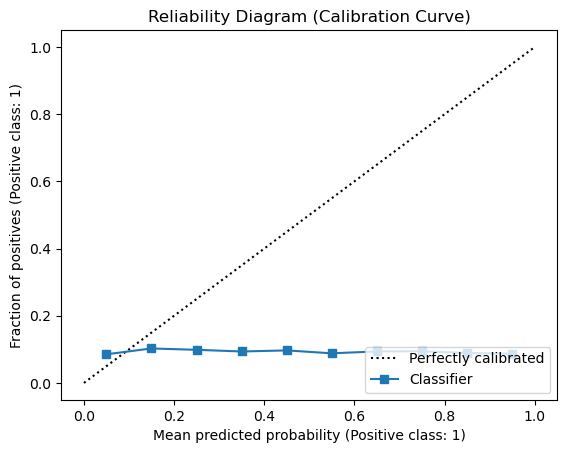

In [70]:
roc_curve_and_auc(y_val, predictions["Random Baseline"]["y_prob"])
goal_rate_by_percentile(y_val, predictions["Random Baseline"]["y_prob"])
cumulative_proportion_of_goals(y_val, predictions["Random Baseline"]["y_prob"])